# Code from hackett (for reference only)
### see: https://github.com/pnnl-predictive-phenomics/emll/blob/hackett_methods/notebooks/run_hackett_inference.py

In [ ]:
# Code to run the ADVI inference with a near-genome scale model and relative
# omics data.

# So I've found that for certain hardware (the intel chips on the cluster here,
# for instance) the intel python and mkl-numpy are about 2x as fast as the
# openblas versions. You can delete a bunch of this stuff if it doesn't work
# for you. This example is a lot slower than some of the other ones though, but
# I guess that's expected

import os
import pandas as pd
import numpy as np
import pymc as pm
import pytensor.tensor as T
import cobra
import emll
from emll.util import initialize_elasticity

os.environ["MKL_THREADING_LAYER"] = "GNU"

# Load model and data
model = cobra.io.load_yaml_model("data/jol2012.yaml")

r_compartments = [r.compartments if "e" not in r.compartments else "t" for r in model.reactions]

r_compartments[model.reactions.index("SUCCt2r")] = "c"
r_compartments[model.reactions.index("ACt2r")] = "c"

for rxn in model.exchanges:
    r_compartments[model.reactions.index(rxn)] = "t"

m_compartments = [m.compartment for m in model.metabolites]

v_star = pd.read_csv("data/v_star.csv", header=None, index_col=0)[1]

x = pd.read_csv("data/metabolite_concentrations.csv", index_col=0)
v = pd.read_csv("data/boundary_fluxes.csv", index_col=0)
e = pd.read_csv("data/enzyme_measurements.csv", index_col=0)

# Reindex arrays to have the same column ordering
to_consider = v.columns
v = v.loc[:, to_consider]
x = x.loc[:, to_consider]
e = e.loc[:, to_consider]

n_exp = len(to_consider) - 1
ref_state = "P0.11"

xn = (x.subtract(x["P0.11"], 0) * np.log(2)).T
en = (2 ** e.subtract(e["P0.11"], 0)).T

# To calculate vn, we have to merge in the v_star series and do some
# calculations.
v_star_df = pd.DataFrame(v_star).reset_index().rename(columns={0: "id", 1: "flux"})
v_merge = v.merge(v_star_df, left_index=True, right_on="id").set_index("id")
vn = v_merge.divide(v_merge.flux, axis=0).drop("flux", axis=1).T

# Drop reference state
vn = vn.drop(ref_state)
xn = xn.drop(ref_state)
en = en.drop(ref_state)

# Get indexes for measured values
x_inds = np.array([model.metabolites.index(met) for met in xn.columns])
e_inds = np.array([model.reactions.index(rxn) for rxn in en.columns])
v_inds = np.array([model.reactions.index(rxn) for rxn in vn.columns])

e_laplace_inds = []
e_zero_inds = []

for i, rxn in enumerate(model.reactions):
    if rxn.id not in en.columns:
        if ("e" not in rxn.compartments) and (len(rxn.compartments) == 1):
            e_laplace_inds += [i]
        else:
            e_zero_inds += [i]

e_laplace_inds = np.array(e_laplace_inds)
e_zero_inds = np.array(e_zero_inds)
e_indexer = np.hstack([e_inds, e_laplace_inds, e_zero_inds]).argsort()

N = cobra.util.create_stoichiometric_matrix(model)
Ex = emll.util.create_elasticity_matrix(model)
Ey = emll.util.create_Ey_matrix(model)

Ex *= 0.1 + 0.8 * np.random.rand(*Ex.shape)

ll = emll.LinLogLeastNorm(N, Ex, Ey, v_star.values, driver="gelsy")

np.random.seed(1)


# Define the probability model

with pm.Model() as pymc_model:
    # Priors on elasticity values
    Ex_t = pm.Deterministic(
        "Ex",
        initialize_elasticity(
            ll.N,
            b=0.01,
            sigma=1,
            alpha=None,
            m_compartments=m_compartments,
            r_compartments=r_compartments,
        ),
    )

    Ey_t = T.as_tensor_variable(Ey)

    e_measured = pm.Normal("log_e_measured", mu=np.log(en), sigma=0.2, shape=(n_exp, len(e_inds)))
    e_unmeasured = pm.Laplace("log_e_unmeasured", mu=0, b=0.1, shape=(n_exp, len(e_laplace_inds)))
    log_en_t = T.concatenate(
        [e_measured, e_unmeasured, T.zeros((n_exp, len(e_zero_inds)))], axis=1
    )[:, e_indexer]

    pm.Deterministic("log_en_t", log_en_t)

    # Priors on external concentrations
    yn_t = pm.Normal(
        "yn_t", mu=0, sigma=10, shape=(n_exp, ll.ny), initval=0.1 * np.random.randn(n_exp, ll.ny)
    )

    chi_ss, vn_ss = ll.steady_state_pytensor(Ex_t, Ey_t, T.exp(log_en_t), yn_t)
    pm.Deterministic("chi_ss", chi_ss)
    pm.Deterministic("vn_ss", vn_ss)

    log_vn_ss = T.log(T.clip(vn_ss[:, v_inds], 1e-8, 1e8))
    log_vn_ss = T.clip(log_vn_ss, -1.5, 1.5)

    chi_clip = T.clip(chi_ss[:, x_inds], -1.5, 1.5)

    chi_obs = pm.Normal("chi_obs", mu=chi_clip, sigma=0.2, observed=xn.clip(lower=-1.5, upper=1.5))
    log_vn_obs = pm.Normal(
        "vn_obs", mu=log_vn_ss, sigma=0.1, observed=np.log(vn).clip(lower=-1.5, upper=1.5)
    )

Consider a probablistic programming problem where we want to utilize different data types for a biological modeling of Bayesian metabolic control analysis with elasticities.
There are different observation types, with each observation type having a set of model variables (like metabolite concentrations) measured and multiple experimental conditions (i.e. protocol A, protocol B, etc.). The tricky part is that for the different observation types, we don't necessarily have an intersection of experimental conditions - meaning we don't necessarily have the same conditions studied for different observations. Similarly, for a given observation time, certain variables may not have been observed for certain conditions. 
Essentially, there are 2 sources of missing information - missing conditions and missing model variable observations across the different observation types and experiments. 

We want to create a function that we can use with pyMC and pyTensor that will help us set up the Bayesian priors. 

The idea is that we first input a dataframe that contains all the conditions across all observation types and all the model variables for a particular observation type.
In the data frame the values will be either the observed quantity (i.e. a float), a '0' if this variable should not be included in the bayesian model, and a 'NaN' if the variable was not observed but we want to potentially included it in the model.

For model variables that have an observed quantity for a given condition, we assign a normal prior, Normal(0,1).
For model variables that have a 0 value for a given condition, we assign a 0 for the prior - i.e. it's not in the model. 
For model variables that have a 'NaN' value for a given condition, we assign a Laplace prior. 

We should create a mapping or list of indexes so we can track which model variable and condition has which quantitiy and prior. 



# simple example

In [12]:
import pandas as pd
import numpy as np
import pymc as pm

def set_priors(df: pd.DataFrame):
    '''Set priors in dataframe based on model variable value for a given condition.'''
    priors = []
    index_map = []

    # TODO: use a more efficient way to get indices
    for i, row in df.iterrows():
        for j, value in enumerate(row):
            if pd.isnull(value):  # NaN value
                prior = pm.Laplace.dist(mu=0, b=1)
            elif value == 0:  # Zero value
                prior = 0
            else:  # Observed quantity
                prior = pm.Normal.dist(mu=value, sigma=1)
            priors.append(prior)
            index_map.append((i, df.columns[j]))

    return priors, index_map

# Create a test dataframe
df = pd.DataFrame({
    'variable_x': [1.2, 0, np.nan],
    'variable_y': [0, 2.3, np.nan],
    'variable_z': [np.nan, 0, 3.4]
}, index=['condition_A', 'condition_B', 'condition_C'])

# Run the function
priors, index_map = set_priors(df)

# Print the results
for index, prior in zip(index_map, priors):
    condition_name, variable_name = index
    value = df.at[condition_name, variable_name]
    print(f'Index: {index}, Variable: {variable_name}, Condition: {condition_name}, Value: {value}, Prior: {prior}')


Index: ('condition_A', 'variable_x'), Variable: variable_x, Condition: condition_A, Value: 1.2, Prior: normal_rv{0, (0, 0), floatX, False}.out
Index: ('condition_A', 'variable_y'), Variable: variable_y, Condition: condition_A, Value: 0.0, Prior: 0
Index: ('condition_A', 'variable_z'), Variable: variable_z, Condition: condition_A, Value: nan, Prior: laplace_rv{0, (0, 0), floatX, False}.out
Index: ('condition_B', 'variable_x'), Variable: variable_x, Condition: condition_B, Value: 0.0, Prior: 0
Index: ('condition_B', 'variable_y'), Variable: variable_y, Condition: condition_B, Value: 2.3, Prior: normal_rv{0, (0, 0), floatX, False}.out
Index: ('condition_B', 'variable_z'), Variable: variable_z, Condition: condition_B, Value: 0.0, Prior: 0
Index: ('condition_C', 'variable_x'), Variable: variable_x, Condition: condition_C, Value: nan, Prior: laplace_rv{0, (0, 0), floatX, False}.out
Index: ('condition_C', 'variable_y'), Variable: variable_y, Condition: condition_C, Value: nan, Prior: laplace_

## setting priors in a pymc model context as a function

Using both informed and uninformed priors

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [variable_x_condition_A_measured, variable_x_condition_C_unmeasured, variable_y_condition_B_measured, variable_y_condition_C_unmeasured, variable_z_condition_A_unmeasured, variable_z_condition_C_measured]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


                                   mean    sd  hdi_3%  hdi_97%  mcse_mean  \
variable_x_condition_A_measured    1.17  1.00   -0.57     3.15       0.02   
variable_x_condition_C_unmeasured -0.01  1.41   -2.67     2.87       0.03   
variable_y_condition_B_measured    2.31  1.00    0.44     4.15       0.02   
variable_y_condition_C_unmeasured  0.00  1.40   -2.74     2.82       0.03   
variable_z_condition_A_unmeasured -0.01  1.42   -2.94     2.67       0.03   
variable_z_condition_C_measured    3.39  0.99    1.54     5.30       0.02   

                                   mcse_sd  ess_bulk  ess_tail  r_hat  
variable_x_condition_A_measured       0.01   2768.07   2878.31    1.0  
variable_x_condition_C_unmeasured     0.03   2322.22   1522.71    1.0  
variable_y_condition_B_measured       0.01   3479.27   2615.83    1.0  
variable_y_condition_C_unmeasured     0.03   3182.19   1626.27    1.0  
variable_z_condition_A_unmeasured     0.03   2877.82   1851.56    1.0  
variable_z_condition_C_measu

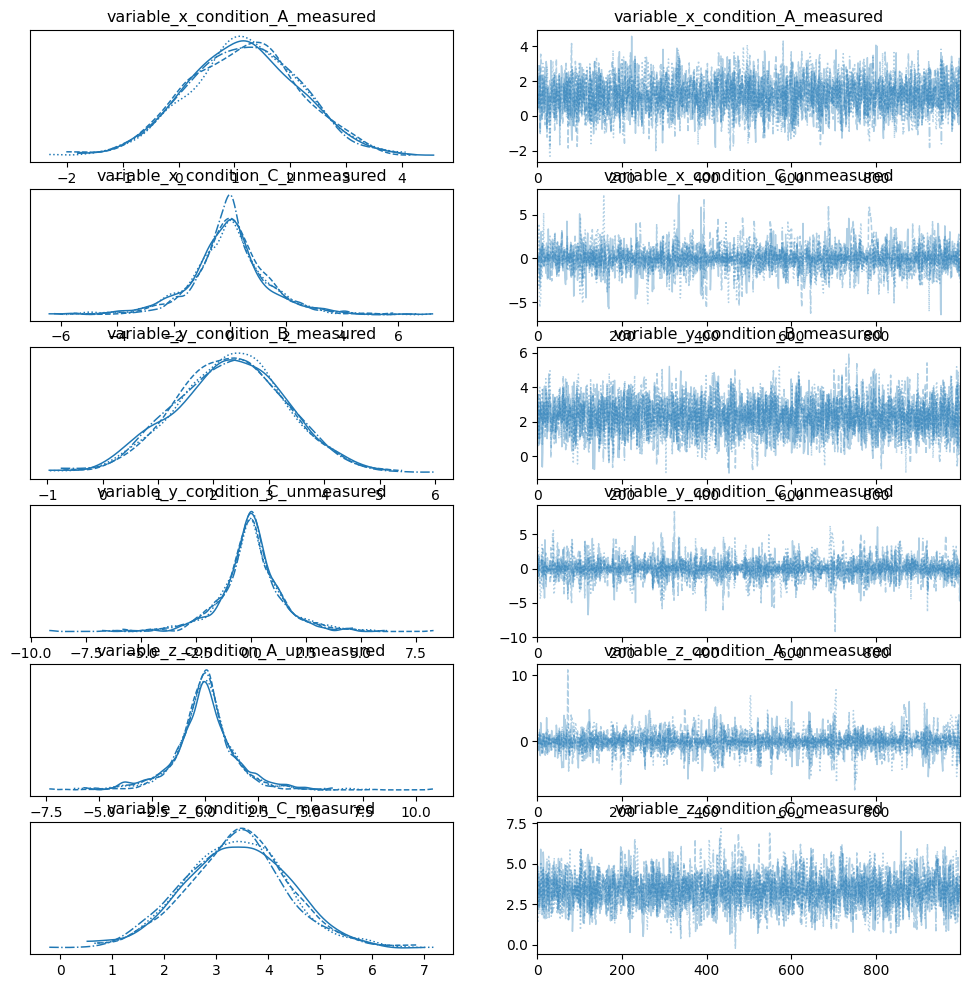

In [17]:
import pymc as pm
import pandas as pd
import numpy as np

def set_priors(df: pd.DataFrame, model: pm.Model, informed_priors=False):
    '''Set priors in dataframe based on model variable value for a given condition.'''
    with model:
        priors = {}
        for var_name in df.columns:
            for i, value in enumerate(df[var_name]):
                condition_name = df.index[i]
                if pd.isnull(value):  # NaN value
                    prior = pm.Laplace(f'{var_name}_{condition_name}_unmeasured', mu=0, b=1)
                elif value == 0:  # Zero value
                    # No need to create a deterministic variable for zero, simply use the value
                    prior = 0
                else:  # Observed quantity
                    if informed_priors:
                        prior = pm.Normal(f'{var_name}_{condition_name}_measured', mu=0, sigma=1, observed=value)
                    else:
                        prior = pm.Normal(f'{var_name}_{condition_name}_measured', mu=value, sigma=1)
                priors[(condition_name, var_name)] = prior
    return priors

# Example usage:
with pm.Model() as pymc_model:
    # Create a test dataframe
    df = pd.DataFrame({
        'variable_x': [1.2, 0, np.nan],
        'variable_y': [0, 2.3, np.nan],
        'variable_z': [np.nan, 0, 3.4]
    }, index=['condition_A', 'condition_B', 'condition_C'])

    # Run the function to set priors w/o informed priors
    priors = set_priors(df, pymc_model)

    # Run inference
    trace = pm.sample(1000, chains=4, return_inferencedata=True)

# Analyze the results
with pymc_model:
    pm.plot_trace(trace)
    summary = pm.summary(trace, round_to=2)
    print(summary)



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [variable_x_condition_C_unmeasured, variable_y_condition_C_unmeasured, variable_z_condition_A_unmeasured]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


                                   mean    sd  hdi_3%  hdi_97%  mcse_mean  \
variable_x_condition_C_unmeasured  0.01  1.53   -3.13     3.02       0.04   
variable_y_condition_C_unmeasured -0.01  1.37   -2.95     2.35       0.03   
variable_z_condition_A_unmeasured  0.07  1.47   -2.94     2.61       0.05   

                                   mcse_sd  ess_bulk  ess_tail  r_hat  
variable_x_condition_C_unmeasured     0.04   1823.90   1363.02    1.0  
variable_y_condition_C_unmeasured     0.03   2188.04   1466.87    1.0  
variable_z_condition_A_unmeasured     0.05   1949.53   1046.24    1.0  


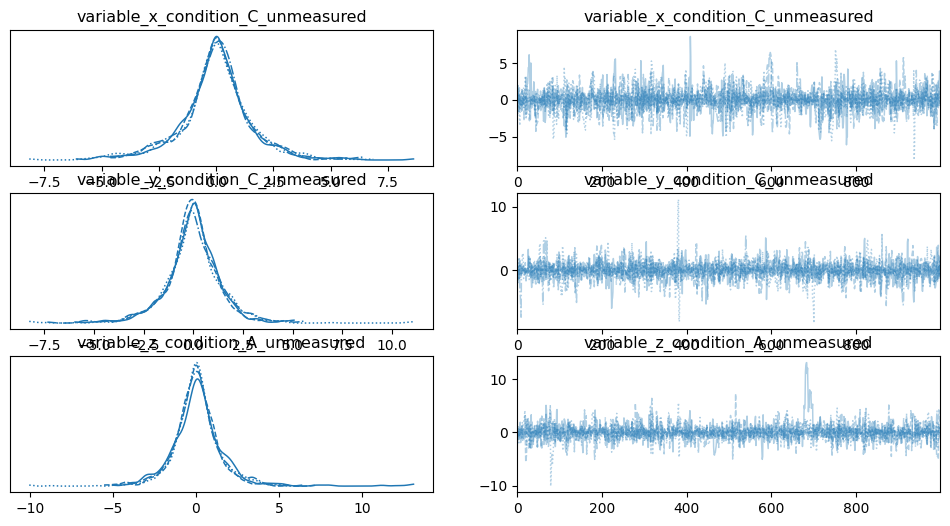

In [18]:
# Example usage:
with pm.Model() as pymc_model:
    # Create a test dataframe
    df = pd.DataFrame({
        'variable_x': [1.2, 0, np.nan],
        'variable_y': [0, 2.3, np.nan],
        'variable_z': [np.nan, 0, 3.4]
    }, index=['condition_A', 'condition_B', 'condition_C'])

    # Run the function to set priors w/ informed priors
    informed_priors = set_priors(df, pymc_model, informed_priors=True)

    # Run inference
    informed_trace = pm.sample(1000, chains=4, return_inferencedata=True)


# Analyze the results
with pymc_model:
    pm.plot_trace(informed_trace)
    summary = pm.summary(informed_trace, round_to=2)
    print(summary)